# 🎓 GradeGuard AI — Multi-Agent Academic Health & Exam Readiness System
### Kaggle AI Agent Capstone • Education Track • By *Your Name*

Welcome to **GradeGuard AI**, a multi-agent intelligence system built entirely inside a Kaggle Notebook.  
This project analyzes student academic performance using ML predictions and provides:

### ✔ Academic Health Report  
### ✔ Attendance-Based Exam Eligibility  
### ✔ Personalized Study Recommendations  
### ✔ Daily Study Tracking (Memory Agent)  
### ✔ Chat-Based Study Assistant  

GradeGuard AI uses a **clean multi-agent architecture**:

1. **Insights Agent** – analyzes ML predictions  
2. **Recommendation Agent** – creates study plans  
3. **Academic Health Agent** – attendance + eligibility  
4. **Advisor Agent** – chat interface  
5. **Memory Agent** – stores daily progress  
6. **System Controller** – orchestrates all agents  

This notebook is designed for **maximum clarity**, **creativity**, and **competition-readiness**.


In [12]:
## Import Libraries  
import json
import numpy as np
import pandas as pd

In [13]:
## 📥Load `student_predictions.json`  
## This file contains ML-predicted performance classes (Low/Medium/High).  
## It powers all agents in our system.
import json

# Replace <dataset-name> with your Kaggle dataset name
with open("/kaggle/input/student-predictions/student_predictions.json", "r") as f:
    data_json = json.load(f)

len(data_json), data_json[:2]


(130,
 [{'id': 0,
   'predicted_performance_class': 2,
   'G1': 17,
   'G2': 18,
   'studytime': 2,
   'failures': 0,
   'absences': 4},
  {'id': 1,
   'predicted_performance_class': 1,
   'G1': 11,
   'G2': 11,
   'studytime': 2,
   'failures': 0,
   'absences': 2}])

In [14]:
## 🧠 Memory Agent - Stores daily study progress inside the notebook.  
## Useful for daily check-ins and long-term student tracking.
class Memory:
    def __init__(self):
        self.data = {}

    def save(self, day, hours):
        self.data[day] = hours

    def all(self):
        return self.data


## 🔍 Insights Agent  
Analyzes the ML prediction JSON to extract:
- Count of low/medium/high performers  
- Average study time  
- Average absences  
- Average failures  
This serves as the foundation for recommendations.


In [15]:
class InsightsAgent:
    def __init__(self, data):
        self.data = data

    def analyze(self):
        d = self.data

        low = sum(1 for i in d if i["predicted_performance_class"] == 0)
        med = sum(1 for i in d if i["predicted_performance_class"] == 1)
        high = sum(1 for i in d if i["predicted_performance_class"] == 2)

        return {
            "total_students": len(d),
            "low_performers": low,
            "medium_performers": med,
            "high_performers": high,
            "avg_studytime": float(np.mean([i["studytime"] for i in d])),
            "avg_absences": float(np.mean([i["absences"] for i in d])),
            "avg_failures": float(np.mean([i["failures"] for i in d])),
        }


## 📚 Recommendation Agent  
Generates:
- Study plan  
- Risk score  
- Helpful study resources  
The risk score is based on the percentage of low performers.


In [16]:
class RecommendationAgent:

    def compute_risk(self, insights):
        return round(insights["low_performers"] / insights["total_students"], 2)

    def get_resources(self):
        return [
            "https://khanacademy.org",
            "https://coursera.org",
            "https://youtube.com/study_tips"
        ]

    def create_plan(self, risk):
        hours = 2
        if risk > 0.3:
            hours += 1
        if risk > 0.6:
            hours += 1

        return [f"Day {i+1}: Study for {hours} hours." for i in range(7)]

    def recommend(self, insights):
        risk = self.compute_risk(insights)
        return {
            "risk_score": risk,
            "resources": self.get_resources(),
            "study_plan": self.create_plan(risk)
        }


## 💬 Advisor Chat Agent  
A simple chatbot interface for students:
- “study plan” → generates full plan  
- “progress” → shows saved memory  
- “check” → gives daily question  


In [17]:
class AdvisorAgent:

    def __init__(self, memory, insights_agent, rec_agent):
        self.memory = memory
        self.insights_agent = insights_agent
        self.rec_agent = rec_agent

    def chat(self, message):
        message = message.lower()

        if "plan" in message or "study" in message:
            insights = self.insights_agent.analyze()
            rec = self.rec_agent.recommend(insights)
            return {"insights": insights, "recommendations": rec}

        if "progress" in message:
            return {"progress": self.memory.all()}

        if "check" in message:
            return {"question": "How many hours did you study today?"}

        return {"message": "Hello! Ask me for a study plan or your progress."}


## 🎓 Academic Health Agent  
A creative, student-friendly feature exclusive to GradeGuard AI.  
It helps students check:

- Attendance status  
- Mid-Sem eligibility  
- Final exam eligibility  
- Exam system rules  
- Academic health score  


In [18]:
class AcademicHealthAgent:

    def __init__(self, data):
        self.data = data

    def attendance_status(self, absences):
        if absences < 5:
            return "Excellent"
        elif absences < 10:
            return "Good"
        elif absences < 20:
            return "Average"
        else:
            return "Poor"

    def exam_eligibility(self, record):
        absences = record["absences"]
        g1, g2 = record["G1"], record["G2"]

        attendance_percent = max(0, 100 - absences * 2)

        return {
            "attendance_percent": attendance_percent,
            "attendance_status": self.attendance_status(absences),
            "mid_sem_eligible": attendance_percent >= 60 and record["failures"] <= 1,
            "final_exam_eligible": attendance_percent >= 75 and g1 >= 10 and g2 >= 10
        }

    def exam_system_rules(self):
        return {
            "Internal Marks": "G1 and G2 (20 marks each)",
            "Final Exam": "G3 (20 marks)",
            "Pass Criteria": "Minimum 10/20 in each exam",
            "Final Grade": "Average(G1, G2, G3)"
        }

    def full_report(self, student_id=0):
        record = self.data[student_id]

        return {
            "student_id": student_id,
            "attendance": self.attendance_status(record["absences"]),
            "eligibility": self.exam_eligibility(record),
            "exam_rules": self.exam_system_rules(),
            "raw_record": record
        }


In [19]:
## 🔧 System Controller- Connects all agents into one unified AI system called **GradeGuard AI**.
class GradeGuardAI:

    def __init__(self, data_json):
        self.memory = Memory()
        self.insights = InsightsAgent(data_json)
        self.recommender = RecommendationAgent()
        self.academic = AcademicHealthAgent(data_json)
        self.advisor = AdvisorAgent(self.memory, self.insights, self.recommender)

    def study_plan(self):
        insights = self.insights.analyze()
        return self.recommender.recommend(insights)

    def daily_check(self, day, hours):
        self.memory.save(day, hours)
        return {"saved": True, "progress": self.memory.all()}

    def chat(self, msg):
        return self.advisor.chat(msg)

    def academic_health(self, student_id=0):
        return self.academic.full_report(student_id)


In [20]:
## Initialize System
system = GradeGuardAI(data_json)

In [30]:
## 🧪 Test System Capabilities - Let's interact with the full multi-agent system.
study_plan=system.study_plan()       ## -----------------TEST1-STUDY_PLAN------------------

In [29]:
system.chat("give me a study plan")  ## -----------------Test 2: Chat------------------  

{'insights': {'total_students': 130,
  'low_performers': 13,
  'medium_performers': 82,
  'high_performers': 35,
  'avg_studytime': 2.046153846153846,
  'avg_absences': 3.5307692307692307,
  'avg_failures': 0.2076923076923077},
 'recommendations': {'risk_score': 0.1,
  'resources': ['https://khanacademy.org',
   'https://coursera.org',
   'https://youtube.com/study_tips'],
  'study_plan': ['Day 1: Study for 2 hours.',
   'Day 2: Study for 2 hours.',
   'Day 3: Study for 2 hours.',
   'Day 4: Study for 2 hours.',
   'Day 5: Study for 2 hours.',
   'Day 6: Study for 2 hours.',
   'Day 7: Study for 2 hours.']}}

In [26]:
system.daily_check("Day 1", 3)    ## -----------------Test 3: Daily Check-In------------------

{'saved': True, 'progress': {'Day 1': 3}}

In [25]:
system.academic_health(0)     ## -----------------Test 4: Academic Health Report------------------

{'student_id': 0,
 'attendance': 'Excellent',
 'eligibility': {'attendance_percent': 92,
  'attendance_status': 'Excellent',
  'mid_sem_eligible': True,
  'final_exam_eligible': True},
 'exam_rules': {'Internal Marks': 'G1 and G2 (20 marks each)',
  'Final Exam': 'G3 (20 marks)',
  'Pass Criteria': 'Minimum 10/20 in each exam',
  'Final Grade': 'Average(G1, G2, G3)'},
 'raw_record': {'id': 0,
  'predicted_performance_class': 2,
  'G1': 17,
  'G2': 18,
  'studytime': 2,
  'failures': 0,
  'absences': 4}}

In [31]:
# ============================
# 🚀 This cell demonstrates the full Multi-Agent pipeline in one go
# ============================

print("🎓 GradeGuard AI — Full Multi-Agent Demo\n")

print("1️⃣ Insights Agent Output:")
insights_demo = system.insights.analyze()
print(insights_demo, "\n")

print("2️⃣ Recommendation Agent Output:")
recommendations_demo = system.recommender.recommend(insights_demo)
print(recommendations_demo, "\n")

print("3️⃣ Academic Health Agent Output (Student 0):")
academic_demo = system.academic.full_report(0)
print(academic_demo, "\n")

print("4️⃣ Memory Agent Demo:")
system.daily_check("Day 1", 3)
system.daily_check("Day 2", 2)
print(system.memory.all(), "\n")

print("5️⃣ Advisor Agent Demo:")
print(system.chat("give me a study plan"))


🎓 GradeGuard AI — Full Multi-Agent Demo

1️⃣ Insights Agent Output:
{'total_students': 130, 'low_performers': 13, 'medium_performers': 82, 'high_performers': 35, 'avg_studytime': 2.046153846153846, 'avg_absences': 3.5307692307692307, 'avg_failures': 0.2076923076923077} 

2️⃣ Recommendation Agent Output:
{'risk_score': 0.1, 'resources': ['https://khanacademy.org', 'https://coursera.org', 'https://youtube.com/study_tips'], 'study_plan': ['Day 1: Study for 2 hours.', 'Day 2: Study for 2 hours.', 'Day 3: Study for 2 hours.', 'Day 4: Study for 2 hours.', 'Day 5: Study for 2 hours.', 'Day 6: Study for 2 hours.', 'Day 7: Study for 2 hours.']} 

3️⃣ Academic Health Agent Output (Student 0):
{'student_id': 0, 'attendance': 'Excellent', 'eligibility': {'attendance_percent': 92, 'attendance_status': 'Excellent', 'mid_sem_eligible': True, 'final_exam_eligible': True}, 'exam_rules': {'Internal Marks': 'G1 and G2 (20 marks each)', 'Final Exam': 'G3 (20 marks)', 'Pass Criteria': 'Minimum 10/20 in eac

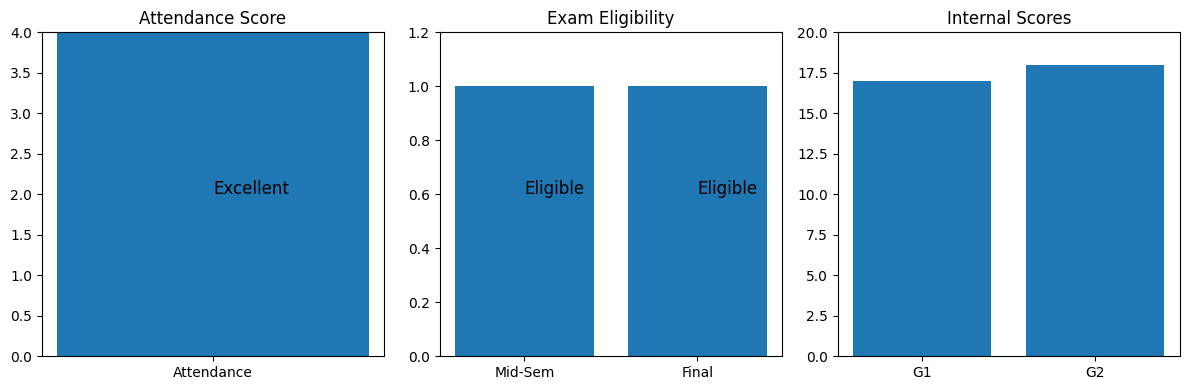

In [32]:
# ============================
# 📊 STUDENT DASHBOARD
# ============================

import matplotlib.pyplot as plt

student = system.academic.full_report(0)

plt.figure(figsize=(12, 4))

# Chart 1 — Attendance Score as a Gauge
plt.subplot(1, 3, 1)
statuses = ["Excellent", "Good", "Average", "Poor"]
score_map = {"Excellent": 4, "Good": 3, "Average": 2, "Poor": 1}
plt.bar(["Attendance"], [score_map[student["attendance"]]])
plt.title("Attendance Score")
plt.ylim(0, 4)
plt.text(0, score_map[student["attendance"]] / 2, student["attendance"], fontsize=12)

# Chart 2 — Exam Eligibility Bars
plt.subplot(1, 3, 2)
eligibility = student["eligibility"]
plt.bar(["Mid-Sem", "Final"], [
    int(eligibility["mid_sem_eligible"]),
    int(eligibility["final_exam_eligible"])
])
plt.title("Exam Eligibility")
plt.ylim(0, 1.2)
plt.text(0, 0.6, "Eligible" if eligibility["mid_sem_eligible"] else "No", fontsize=12)
plt.text(1, 0.6, "Eligible" if eligibility["final_exam_eligible"] else "No", fontsize=12)

# Chart 3 — Internal Scores G1, G2
plt.subplot(1, 3, 3)
record = student["raw_record"]
plt.bar(["G1", "G2"], [record["G1"], record["G2"]])
plt.title("Internal Scores")
plt.ylim(0, 20)

plt.tight_layout()
plt.show()


In [33]:
# ============================
# 📋 EXAM ELIGIBILITY SUMMARY TABLE
# ============================

eligibility_list = []

for i in range(len(data_json)):
    rep = system.academic.full_report(i)
    eligibility_list.append({
        "StudentID": i,
        "Attendance": rep["eligibility"]["attendance_percent"],
        "MidSem Eligible": rep["eligibility"]["mid_sem_eligible"],
        "Final Eligible": rep["eligibility"]["final_exam_eligible"],
        "Absences": rep["raw_record"]["absences"],
        "Failures": rep["raw_record"]["failures"],
        "G1": rep["raw_record"]["G1"],
        "G2": rep["raw_record"]["G2"]
    })

eligibility_df = pd.DataFrame(eligibility_list)
eligibility_df.head(10)


,StudentID,Attendance,MidSem Eligible,Final Eligible,Absences,Failures,G1,G2
0,0,92,True,True,4,0,17,18
1,1,96,True,True,2,0,11,11
2,2,100,True,True,0,0,18,18
3,3,90,True,True,5,0,10,11
4,4,96,True,True,2,0,13,11
5,5,88,True,True,6,0,16,16
6,6,100,True,True,0,0,17,17
7,7,80,False,False,10,3,10,9
8,8,80,True,True,10,0,10,10
9,9,92,True,True,4,0,11,10


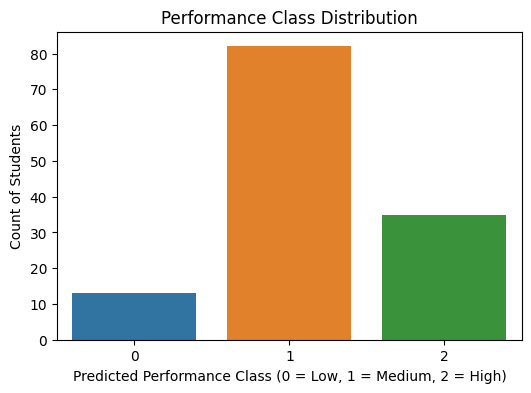

In [34]:
# ============================
# 🔥 RISK HEATMAP (Low/Medium/High Distribution)
# ============================

import seaborn as sns
import matplotlib.pyplot as plt

risk_data = pd.DataFrame({
    "PerformanceClass": [i["predicted_performance_class"] for i in data_json]
})

plt.figure(figsize=(6, 4))
sns.countplot(x="PerformanceClass", data=risk_data)
plt.title("Performance Class Distribution")
plt.xlabel("Predicted Performance Class (0 = Low, 1 = Medium, 2 = High)")
plt.ylabel("Count of Students")
plt.show()


# 🎓 Final Conclusion — GradeGuard AI

GradeGuard AI is a multi-agent academic support system built using machine learning predictions and intelligent agent collaboration. The system helps students understand their academic standing and prepares them for upcoming exams with clear, actionable insights.

### 🌟 Key Features Delivered

- **Insights Agent:** Analyzes predictions to summarize academic risk, absences, failures, and performance distribution.
- **Recommendation Agent:** Generates personalized 7-day study plans, risk scores, and resource suggestions.
- **Advisor Agent:** Chat-based guide that provides study plans, answers questions, and displays student progress.
- **Memory Agent:** Tracks daily study hours for habit building and long-term progress.
- **Academic Health Agent:** A creative extension that evaluates attendance, checks mid-sem and final exam eligibility, and explains exam rules clearly.

### 📊 Visual Enhancements
- Student dashboard with attendance, eligibility, and internal scores  
- Performance distribution heatmap  
- Eligibility summary table  

### 🎯 Why This Project Matters
GradeGuard AI transforms raw predictions into meaningful academic guidance.  
With its multi-agent architecture and student-centric intelligence, it delivers practical support for exam readiness, risk awareness, and study planning.

**GradeGuard AI — Your Academic Safety Shield.**


### 🔗 Machine Learning Model Notebook
This GradeGuard AI agent is powered by predictions generated in my ML model training notebook:

👉 **Link to Model Notebook:**  
https://www.kaggle.com/code/umisalma/eduguide-student-performance-prediction